In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

In [2]:
h5_a_file_name = '17_point_single_frame_processed_data_old_prototype.hdf5'
h5_b_file_name = '17_point_single_frame_processed_data_new_prototype.hdf5'
h5_file_name = '17_point_single_frame_processed_data.hdf5'

h5_a = h5py.File(h5_a_file_name, 'r')
h5_b = h5py.File(h5_b_file_name, 'r')
hf_tot = h5py.File(h5_file_name, 'w')

In [7]:
time_window_size = 15
examples_per_edge = 3

In [3]:
#combine data
hf_tot.create_dataset('contact_status', data=h5_a['contact_status'], maxshape=(None,))
hf_tot.create_dataset('time_steps', data=h5_a['time_steps'], maxshape=(None,))
hf_tot.create_dataset('event_images', data=h5_a['event_images'], maxshape=(None, None, None, None))

hf_tot['contact_status'].resize(len(hf_tot['contact_status']) + len(h5_b['contact_status']), axis=0)
hf_tot["contact_status"][-len(h5_b['contact_status']):] = h5_b['contact_status']

hf_tot['time_steps'].resize(len(hf_tot['time_steps']) + len(h5_b['time_steps']), axis=0)
hf_tot["time_steps"][-len(h5_b['time_steps']):] = h5_b['time_steps']

hf_tot['event_images'].resize(len(hf_tot['event_images']) + len(h5_b['event_images']), axis=0)
hf_tot["event_images"][-len(h5_b['event_images']):] = h5_b['event_images']

hf_tot.close()
h5_a.close()
h5_b.close()

In [4]:
hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['event_images'])))
hf.close()

number of event images: 17028


In [10]:
#Find rise/drop time and create windows accordingle
hf = h5py.File(h5_file_name, 'r+')
edge_locations = np.where(np.abs(np.diff(hf['contact_status']))>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)
hf.close()

#Divide the data set into windows

def extract_edge_data(hf_file, edge_index_list, n_examples_per_edge=examples_per_edge, window_size=time_window_size, n_classes=18):
    for i in range(len(edge_index_list)):
        index = edge_index_list[i]

        for j in range(n_examples_per_edge):
            if hf_file['contact_status'][index+1] == 0:
                #fall edge case
                start_index = max([0, math.floor(index+5)])
                end_index = start_index + window_size               
            else:
                #rise edge case
                start_index = max([0, math.floor(index-window_size/2)])
                end_index = start_index + window_size

            if end_index <= len(hf_file['contact_status']):
                reference_idx = range(int(start_index), int(end_index))
                one_hot_vector = [0] * n_classes
                one_hot_vector[int(hf_file['contact_status'][end_index])] = 1
                
                if not ('ex_input_image_idx' in hf_file.keys()):
                    hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
                    hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
                else:
                    hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
                    hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

                    hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
                    hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector


[47, 68, 97, 117, 145, 167, 196, 217, 243, 267, 295, 317, 347, 367, 397, 417, 447, 467, 497, 518, 545, 568, 596, 618, 646, 668, 694, 718, 745, 767, 796, 818, 845, 867, 897, 918, 944, 968, 994, 1018, 1047, 1067, 1097, 1117, 1147, 1167, 1197, 1219, 1248, 1268, 1297, 1319, 1348, 1368, 1396, 1419, 1448, 1469, 1497, 1518, 1547, 1567, 1597, 1618, 1645, 1668, 1695, 1719, 1748, 1769, 1798, 1818, 1846, 1869, 1896, 1918, 1945, 1968, 1996, 2019, 2048, 2069, 2097, 2118, 2146, 2169, 2198, 2219, 2248, 2269, 2296, 2319, 2348, 2369, 2397, 2419, 2448, 2468, 2498, 2518, 2546, 2569, 2598, 2618, 2648, 2668, 2699, 2718, 2749, 2770, 2798, 2820, 2849, 2870, 2899, 2919, 2949, 2971, 3000, 3019, 3048, 3070, 3099, 3120, 3146, 3169, 3195, 3220, 3249, 3270, 3299, 3319, 3347, 3370, 3399, 3419, 3449, 3470, 3497, 3520, 3549, 3570, 3596, 3620, 3649, 3669, 3699, 3719, 3750, 3770, 3798, 3820, 3850, 3870, 3899, 3920, 3948, 3970, 3997, 4020, 4049, 4070, 4099, 4119, 4149, 4171, 4197, 4221, 4248, 4270, 4300, 4321, 4350, 437

In [11]:
hf = h5py.File(h5_file_name, 'r+')
extract_edge_data(hf, edge_locations)
hf.close()

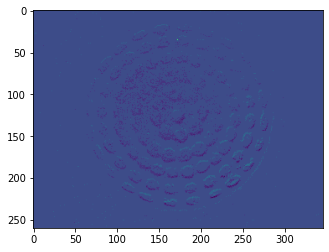

In [19]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 100
plt.imshow(hf['event_images'][edge_locations[indx]][:,:,0])
plt.show
hf.close()

[1017, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]


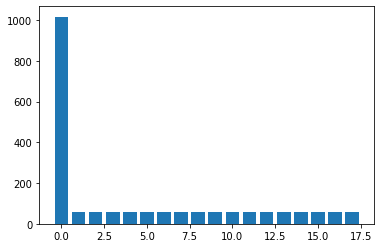

In [20]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [21]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(len(hf_file['ex_output'])):
        idx = list(hf['ex_output'][i]).index(1)
        
        if (np.random.rand() < (float(min(counter)) / counter[idx])):
            if 'ex_input_image_idx_equalized' in hf_file.keys():
                hf_file['ex_input_image_idx_equalized'].resize(len(hf_file['ex_input_image_idx_equalized']) + 1, axis=0)
                hf_file["ex_input_image_idx_equalized"][len(hf_file['ex_input_image_idx_equalized'])-1] = hf_file['ex_input_image_idx'][i]

                hf_file['ex_output_equalized'].resize(len(hf_file['ex_output_equalized']) + 1, axis=0)
                hf_file["ex_output_equalized"][len(hf_file['ex_output_equalized'])-1] = hf['ex_output'][i]
            else:
                hf_file.create_dataset('ex_input_image_idx_equalized', data=[hf_file['ex_input_image_idx'][i]], maxshape=(None,None))
                hf_file.create_dataset('ex_output_equalized', data=[hf_file['ex_output'][i]], maxshape=(None, None))

equalize_representation(hf, counter)

[57, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]


<BarContainer object of 18 artists>

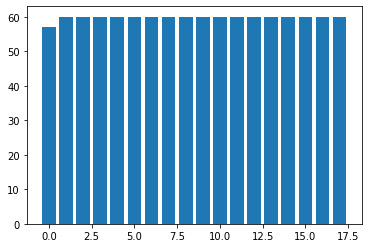

In [22]:
new_counter = [0] * 18

for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)

In [23]:
hf.close()